# imCPP: Feature Extraction

In [1]:
    from typing import List, Tuple
    import gzip
    import numpy as np
    from dataclasses import dataclass

    @dataclass
    class DatasetParameters:
        map_width: int = 10
        map_count: int = 600
        problem_count: int = 10
        obstacle_count: int = 10
        agent_count: int = 4


    def bits_to_bytes(data: str) -> bytes:    
        return bytes([int(data[i * 8 : (i + 1) * 8], 2) for i in range(len(data) // 8)])



    def bytes_to_bits(data: bytes) -> str:
        return ''.join('{:08b}'.format(byte) for byte in data)


    class DatasetEncoder:    

        def __init__(
            self,
            parameters: DatasetParameters,
        ):
            self.map_width = parameters.map_width
            self.map_count = parameters.map_count
            self.problem_count = parameters.problem_count
            self.obstacle_count = parameters.obstacle_count
            self.agent_count = parameters.agent_count
            self.coordinate_length = int(2 * np.ceil(np.log2(self.map_width)))
            self.map_length = int(self.obstacle_count * self.coordinate_length)
            self.problem_length = int(self.agent_count * self.coordinate_length)
            self.solution_length = int(self.map_width ** 2) * 4


        def encode_coordinate(self, coordinate: Tuple) -> str:
            return ('{:0%ib}{:0%ib}' % (self.coordinate_length // 2, self.coordinate_length // 2)).format(*coordinate)


        def decode_coordinate(self, data: str) -> str:
            return int(data[: self.coordinate_length // 2], 2), int(data[self.coordinate_length // 2 :], 2)


        def encode_coordinates(self, map: List) -> str:
            return ''.join(self.encode_coordinate(obstacle) for obstacle in map)


        def decode_coordinates(self, data: str) -> List:
            return list(self.decode_coordinate(data[i * self.coordinate_length : (i + 1) * self.coordinate_length]) for i in range(len(data) // self.coordinate_length))


        def encode_solution(self, solution: np.array) -> str:
            return ''.join(str(bit) for bit in solution.flatten())


        def decode_solution(self, data) -> np.array:
            return np.array(list(data)).astype(int).reshape(self.agent_count, self.map_width, self.map_width)


        def encode_dataset(self, maps: List, problems: List, solutions: List) -> str:

            data = ''

            for map in maps:
                data += self.encode_coordinates(map)

            for problem in problems:
                data += self.encode_coordinates(problem)

            for solution in solutions:
                data += self.encode_solution(solution)


            data += '0' * (len(data) % 8) # padding
            return data 


        def decode_dataset(self, data: str) -> Tuple:

            maps = [self.decode_coordinates(data[i * self.map_length : (i + 1) * self.map_length]) for i in range(self.map_count)]
            data = data[self.map_count * self.map_length :]

            problems = [self.decode_coordinates(data[i * self.problem_length : (i + 1) * self.problem_length]) for i in range(self.map_count * self.problem_count)]
            data = data[self.map_count * self.problem_count * self.problem_length :]

            solutions = [self.decode_solution(data[i * self.solution_length : (i + 1) * self.solution_length]) for i in range(self.map_count * self.problem_count)]
            data = data[self.map_count * self.problem_count * self.solution_length :]

            return maps, problems, solutions


        def encode(self, maps: List, problems: List, solutions: List) -> bytes:
            return gzip.compress(bits_to_bytes(self.encode_dataset(maps, problems, solutions)))


        def decode(self, data: bytes) -> Tuple:
            return self.decode_dataset(bytes_to_bits(gzip.decompress(data)))

In [2]:
dataset_parameters = DatasetParameters(
    map_width=10,
    map_count=600, # since some will not be solved
    problem_count=50,
    obstacle_count=10,
    agent_count=4,
)

In [3]:
dataset_encoder = DatasetEncoder(dataset_parameters)

def load_data(path: str) -> Tuple:
    with open(path, 'rb') as file:
        return dataset_encoder.decode(file.read())

We cast the problem of replicating DARP as a multi-label classification problem. To generate our features we use the following procedure:

* While the map is not covered:
    * For each agent:
        * Pick a cell on the exterior of the agent's sub-area.
        * Gather features $F$ for this cell (e.g. a FOV from the perspective of the cell).
        * Check which adjacent cells are also in the agent's sub-area.
        * Create a training example $(F, C)$ where $C$ is a multi-one-hot encoded label denoting which adjacent cells are included.
        * Add the adjacent cells to the set of potential cells to explore for this agent.
    * Update the map to contain newly explored cells.

It may be possible to inflate the dataset further by converting the multi-one-hot labels to *contrastive* labels. In this case, we train a model to predict whether two nodes are adjacent based on their embeddings. 

## Features For Cells

A key part of this process is our selection of features for each cell. Ideally, we would like to find a set of *local* features which are highly informative towards the task of predicting whether adjacent cells are within an agent's sub-area. The locallity requirement is intended to increase generalization such that models do not rely heavily on the whole layout of a map. Two ideas come to mnid:

1. Local FOV - we consider a small field-of-view arround each cell. The resulting image may have separate channels for other agents and covered cells.
2. GNN features - we use a GNN to learn embeddings of cells based on surrounding cell features. The individual cells features could be DODGE features for instance.

Both feature selections can potentially either be used for multi-label classification or contrastive classification.

## Implementation

We now implement the aforementioned method to create a multi-label classification dataset. We use DODGE features for each node. These will later be integrated into embeddings by a GNN.

In [3]:
def my_decoder():
    
    def decode(data):
        from typing import List, Tuple
        import gzip
        import numpy as np
        from dataclasses import dataclass

        @dataclass
        class DatasetParameters:
            map_width: int = 10
            map_count: int = 600
            problem_count: int = 10
            obstacle_count: int = 10
            agent_count: int = 4


        class DatasetEncoder:    

            def __init__(
                self,
                parameters: DatasetParameters,
            ):
                self.map_width = parameters.map_width
                self.map_count = parameters.map_count
                self.problem_count = parameters.problem_count
                self.obstacle_count = parameters.obstacle_count
                self.agent_count = parameters.agent_count
                self.coordinate_length = int(2 * np.ceil(np.log2(self.map_width)))
                self.map_length = int(self.obstacle_count * self.coordinate_length)
                self.problem_length = int(self.agent_count * self.coordinate_length)
                self.solution_length = int(self.map_width ** 2) * 4

            def decode_coordinates(self, data: str) -> List:
                return list(self.decode_coordinate(data[i * self.coordinate_length : (i + 1) * self.coordinate_length]) for i in range(len(data) // self.coordinate_length))


            def encode_solution(self, solution: np.array) -> str:
                return ''.join(str(bit) for bit in solution.flatten())


            def decode_solution(self, data) -> np.array:
                return np.array(list(data)).astype(int).reshape(self.agent_count, self.map_width, self.map_width)


            def decode_dataset(self, data: str) -> Tuple:

                maps = [self.decode_coordinates(data[i * self.map_length : (i + 1) * self.map_length]) for i in range(self.map_count)]
                data = data[self.map_count * self.map_length :]

                problems = [self.decode_coordinates(data[i * self.problem_length : (i + 1) * self.problem_length]) for i in range(self.map_count * self.problem_count)]
                data = data[self.map_count * self.problem_count * self.problem_length :]

                solutions = [self.decode_solution(data[i * self.solution_length : (i + 1) * self.solution_length]) for i in range(self.map_count * self.problem_count)]
                data = data[self.map_count * self.problem_count * self.solution_length :]

                return maps, problems, solutions


            def decode(self, data: bytes) -> Tuple:
                return self.decode_dataset(bytes_to_bits(gzip.decompress(data)))


        def bits_to_bytes(data: str) -> bytes:    
            return bytes([int(data[i * 8 : (i + 1) * 8], 2) for i in range(len(data) // 8)])


        def bytes_to_bits(data: bytes) -> str:
            return ''.join('{:08b}'.format(byte) for byte in data)


        dataset_parameters = DatasetParameters(
                map_width=10,
                map_count=600, # since some will not be solved
                problem_count=50,
                obstacle_count=10,
                agent_count=4,
        )


        dataset_encoder = DatasetEncoder(dataset_parameters)
        return dataset_encoder.decode(data)

In [22]:
from typing import Callable, Any
import dis
import marshal
import pickle


Data = Any
Decoder = Callable[None, Callable]


def encode(data: Data, decoder: Decoder) -> Data:

        decoder = dis.Bytecode(decoder)
        decoder = marshal.dumps(decoder.codeobj)

        return pickle.dumps((data, decoder))


def decode(data: Data) -> Data:

        data, decoder = pickle.loads(data)
        decoder = marshal.loads(decoder)

        return eval(decoder)(data)


In [18]:
data = open('../data/imcpp-0.gz', 'rb').read()


In [26]:
open('./imcpp0.coco.gz', 'wb').write(gzip.compress(s))

809623

In [4]:
dataset0 = load_data('../data/imcpp-0.gz')
dataset1 = load_data('../data/imcpp-1.gz')

In [5]:
from scipy.spatial.distance import cityblock as manhattan_distance


APF_FACTOR = 1 / dataset_parameters.agent_count
MAX_AGENTS = 30


def create_dodge_features(y, x, map: List, problem: List, solution: np.array, agent_index: int) -> np.array:
    
    agent_y, agent_x = problem[agent_index]

    # Feature 0,1 - coordinate of the cell, relative to the agent.
    # y_relative will be positive if the cell is below the agent.
    # x_relative will be positive if the cell is to the right of the agent.

    y_relative, x_relative = (y - agent_y, x - agent_x)


    # Feature 2 - artificial potential field-based distance from other agents.
    # w(cell) = sum_agent k/(dist(cell, agent) + 1)
    # w(cell) = 0 if cell is an obstacle.

    w = 0
    is_obstacle = 0.

    if (y, x) not in map: # (i.e. not an obstacle)
        w = sum([ (APF_FACTOR / (manhattan_distance((y, x), agent) + 1)) for agent in problem ])

    else:
        is_obstacle = 1.


    # Feature 3 - Occupancy of the cell.
    # One-hot encode the index of the agent occupying the cell. All set to zero if no agents are occupying it. 
    # Last position set to 1 if occupied by an obstacle.

    occupancy = np.zeros(MAX_AGENTS + 1)
    occupancy[-1] = is_obstacle

    for i, sub_area in enumerate(solution):
        if sub_area[y, x]:
            occupancy[i] = 1.

    return (y_relative, x_relative, w, occupancy)         

In [6]:
FOV_RADIUS = 3
FOV_WIDTH = FOV_RADIUS * 2 + 1
FOV_CHANNELS = 3 # 4
FOV_CHANNEL_OBSTACLE = 0
FOV_CHANNEL_AGENT = 1
FOV_CHANNEL_OTHER_AGENT = 2
FOV_CHANNEL_OCCUPANCY = 3

from numpy import linalg 

def compute_non_clipped_view(y, x, coordinates, exclude: set = set()):
    
    coordinates = list(set(coordinates) - exclude)
    view = np.zeros((FOV_WIDTH, FOV_WIDTH))
    
    for (y1, x1) in coordinates:
        
        if (y1, x1) == (y, x):
            view[FOV_RADIUS, FOV_RADIUS] = 1.
        
        elif abs(y1 - y) <= FOV_RADIUS and abs(x1 - x) <= FOV_RADIUS:

            view_y = y1 - y + FOV_RADIUS
            view_x = x1 - x + FOV_RADIUS
            view[view_y, view_x] = 1.
    
    return view

def compute_clipped_view(y, x, coordinates, exclude: set = set()):
    
    coordinates = list(set(coordinates) - exclude)
    view = np.zeros((FOV_WIDTH, FOV_WIDTH))
    
    for (y1, x1) in coordinates:
        
        if (y1, x1) == (y, x):
            view[FOV_RADIUS, FOV_RADIUS] = 1.
        
        elif abs(y1 - y) <= FOV_RADIUS and abs(x1 - x) <= FOV_RADIUS:

            view_y = y1 - y + FOV_RADIUS
            view_x = x1 - x + FOV_RADIUS
            view[view_y, view_x] = 1.
        
        # otherwise, compute the projection...
        
        else:
            projection_vector = np.array([y1 - y, x1 - x]).astype(float)
            projection_vector /= np.linalg.norm(projection_vector)
            ray_vector = np.zeros(2)
            
            while abs(ray_vector[0]) < FOV_RADIUS and abs(ray_vector[1]) < FOV_RADIUS:
                ray_vector += projection_vector
            
            x_offset = int(max(-FOV_RADIUS, min(FOV_RADIUS, ray_vector[1])))
            y_offset = int(max(-FOV_RADIUS, min(FOV_RADIUS, ray_vector[0])))
            
            projection_view_x = FOV_RADIUS + x_offset
            projection_view_y = FOV_RADIUS + y_offset
            view[projection_view_y, projection_view_x] = 1
    
    return view


def create_fov_features(y, x, map: List, problem: List, solution: np.array, agent_index: int) -> np.array:
    
    agent_coordinate = problem[agent_index]
    occupancy_map = solution.sum(axis=0).astype(bool).astype(int)

    fov = np.zeros((FOV_CHANNELS, FOV_WIDTH, FOV_WIDTH))

    fov[FOV_CHANNEL_OBSTACLE] = compute_non_clipped_view(y, x, map) # Channel 0 - non-clipped view of obstacles.
    fov[FOV_CHANNEL_AGENT] = compute_clipped_view(y, x, [ agent_coordinate ]) # Channel 1 - clipped view of the agent.
    fov[FOV_CHANNEL_OTHER_AGENT] = compute_clipped_view(y, x, problem, exclude={ agent_coordinate, }) # Channel 2 - clipped view of other agents.

    # Add out of bounds obstacles...

    for fov_y, y1 in enumerate(range(y - FOV_RADIUS, y + FOV_RADIUS + 1)):
        for fov_x, x1 in enumerate(range(x - FOV_RADIUS, x + FOV_RADIUS + 1)):

            if (y1 < 0) or (x1 < 0) or (y1 > dataset_parameters.map_width - 1) or (x1 > dataset_parameters.map_width - 1):
                fov[FOV_CHANNEL_OBSTACLE, fov_y, fov_x] = 1.
            
            # elif occupancy_map[y1, x1]:
            #     # Channel 3 - occupancy
            #     fov[FOV_CHANNEL_OCCUPANCY][fov_y, fov_x] = 1.
    
    

    return fov

In [7]:
create_fov_features(0,7, dataset0[0][0], dataset0[1][0], dataset0[2][0], 0)

array([[[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]])

In [19]:
create_dodge_features(0, 5, dataset0[0][0], dataset0[1][0], dataset0[2][0], 0)

(-3,
 0,
 0.20833333333333331,
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [20]:
def serialize_solution(map: List, problem: List, solution: np.array) -> np.array:
    
    exterior_cells = [[agent] for agent in problem]
    visited_cells = {}
    gradual_solution = np.zeros_like(solution)
    finished = False
    
    # Add initial positions to gradual solution...
    
    for i, (y, x) in enumerate(problem):
        gradual_solution[i, y, x] = 1.
    
    while not finished:
        finished = True
        
        new_exterior_cells = [[] for _ in problem]
        
        for agent_index, agent in enumerate(problem):
            
            try:
                exterior_cell = np.array(exterior_cells[agent_index].pop(0))
                finished = False
            except:
                continue 
                
            exterior_y, exterior_x = exterior_cell
            #print(f'At cell {(exterior_y, exterior_x)}, agent {agent_index}, total explored cells = {len(visited_cells)}.')
            visited_cells[(exterior_y, exterior_x)] = True
            
            features = create_fov_features(exterior_y, exterior_x, map, problem, gradual_solution, agent_index)
            label = []
            
            for direction in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
                neighbour_y, neighbour_x = exterior_cell + direction
                
                if (neighbour_y < 0) or (neighbour_y >= dataset_parameters.map_width) or (neighbour_x < 0) or (neighbour_x >= dataset_parameters.map_width):
                    label.append(0)
                
                else:
                    neighbour_occupied = solution[agent_index, neighbour_y, neighbour_x]
                    label.append(neighbour_occupied)
                    
                    if neighbour_occupied and not visited_cells.get((neighbour_y, neighbour_x)):
                        
                        #print(f'Adding {(neighbour_y, neighbour_x)} to exterior cells for agent {agent_index}...')
                        new_exterior_cells[agent_index].append((neighbour_y, neighbour_x))
            
            yield features, label
        
        for i, cells in enumerate(new_exterior_cells):
            exterior_cells[i] += cells
            
            for (y, x) in cells:
                gradual_solution[i, y, x] = 1
                
    
    
# def serialize_solution(map: List, problem: List, solution: np.array) -> np.array:
    
#     fresh_cells = [[agent_start_cell] for agent_start_cell in problem]
#     working_solution = np.zeros_like(solution)
    
    

    
    
#     # Add agent start cells to working solutotion
    
#     for i, (y, x) in enumerate(problem):
#         working_solution[i, y, x] = 1.
        
    
#     for step in range(5):
#         for agent_index, (y, x) in enumerate(problem):
            
#             fresh_cell = fresh_cells[agent_index].pop(0)
            
#             input = create_fov_features(fresh_cell[0], fresh_cell[1], map, problem, working_solution, agent_index)
#             label = [0]*4 # multi-label
            
#             for j, (dy, dx) in enumerate([(-1, 0), (0, 1), (1, 0), (0, -1)]): # N,E,S,W
                
#                 if is_cell_occupied_by_agent(agent_index, y + dy, x + dx):
#                     label[j] = 1.
#                     fresh_cells[agent_index].append((y + dy, x + dx))
#                     #working_solution[agent_index, y + dy, x + dx] = 1.
            
#             print(fresh_cells)
#             yield step, agent_index, input, label

#     return working_solution

In [21]:
map, problem, solution = dataset0[0][0], dataset0[1][0], dataset0[2][0]

sol = serialize_solution(map, problem, solution)

In [22]:
next(sol)

(array([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.]]]),
 [0, 0, 1, 0])

In [23]:
# Create training dataset

train_x = []
train_y = []

# train on the first 

for i in range(dataset_parameters.map_count):
    print(f'Serializing map {i} solutions...')
    
    for j in range(dataset_parameters.problem_count):
        
        map = dataset0[0][i]
        problem = dataset0[1][dataset_parameters.problem_count * i + j]
        solution = dataset0[2][dataset_parameters.problem_count * i + j]
        
        serialized_solution = serialize_solution(map, problem, solution)
        
        for features, labels in serialized_solution:
            #x, y, w, o = features            
            #features = np.concatenate(([x, y, w], o))
            
            train_x.append(features)
            train_y.append(labels)

Serializing map 0 solutions...
Serializing map 1 solutions...
Serializing map 2 solutions...
Serializing map 3 solutions...
Serializing map 4 solutions...
Serializing map 5 solutions...
Serializing map 6 solutions...
Serializing map 7 solutions...
Serializing map 8 solutions...
Serializing map 9 solutions...
Serializing map 10 solutions...
Serializing map 11 solutions...
Serializing map 12 solutions...
Serializing map 13 solutions...
Serializing map 14 solutions...
Serializing map 15 solutions...
Serializing map 16 solutions...
Serializing map 17 solutions...
Serializing map 18 solutions...
Serializing map 19 solutions...
Serializing map 20 solutions...
Serializing map 21 solutions...
Serializing map 22 solutions...
Serializing map 23 solutions...
Serializing map 24 solutions...
Serializing map 25 solutions...
Serializing map 26 solutions...
Serializing map 27 solutions...
Serializing map 28 solutions...
Serializing map 29 solutions...
Serializing map 30 solutions...
Serializing map 31


KeyboardInterrupt



In [24]:
limit = 4_000_000

train_y_limit = train_y[: limit]
train_x_limit = train_x[: limit]

In [25]:
train_y_north = [y[0] for y in train_y_limit]
train_y_east = [y[1] for y in train_y_limit]
train_y_south = [y[2] for y in train_y_limit]
train_y_west = [y[3] for y in train_y_limit]

In [26]:
train_y_north.shape

AttributeError: 'list' object has no attribute 'shape'

In [27]:
train_x_limit = [x.flatten() for x in train_x_limit]

In [28]:
split = int(np.array(train_y_limit).shape[0] * 0.7)
split

480477

In [30]:
X_train_1, y_train_1 = train_x_limit[: split], train_y_north[: split]
X_test_1, y_test_1 = train_x_limit[split :], train_y_north[split :]

X_train_2, y_train_2 = train_x_limit[: split], train_y_east[: split]
X_test_2, y_test_2 = train_x_limit[split :], train_y_east[split :]

X_train_3, y_train_3 = train_x_limit[: split], train_y_south[: split]
X_test_3, y_test_3 = train_x_limit[split :], train_y_south[split :]

X_train_4, y_train_4 = train_x_limit[: split], train_y_west[: split]
X_test_4, y_test_4 = train_x_limit[split :], train_y_west[split :]

len(X_train_1), len(X_test_1)

(480477, 205919)

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
from sklearn.naive_bayes import CategoricalNB

In [33]:
from sklearn.neural_network import MLPClassifier

In [39]:
clf = LogisticRegression(max_iter=400).fit(X_train_1, y_train_1)

/home/user/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
clf.score(X_test_1, y_test_1)

0.872255595646832

In [884]:
np.array(X_train).shape

(675817, 4, 7, 7)

In [38]:
clf1 = LogisticRegression().fit(X_train_1, y_train_1) # north classifier
print('training east...')
clf2 = LogisticRegression().fit(X_train_2, y_train_2) # eaast classifier
print('training south...')
clf3 = LogisticRegression().fit(X_train_3, y_train_3) # south classifier
print('training west...')
clf4 = LogisticRegression().fit(X_train_4, y_train_4) # west classificer
print('done')

/home/user/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training east...


/home/user/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training south...


/home/user/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training west...
done


/home/user/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
clf.score(X_test_1, y_test_1)

0.872255595646832

In [43]:
def serialize_classifier_solution(map: List, problem: List, solution: List, classifiers: List) -> np.array:
    
    exterior_cells = [[agent] for agent in problem]
    visited_cells = {}
    gradual_solution = np.zeros_like(solution)
    finished = False
    
    # Add initial positions to gradual solution...
    
    for i, (y, x) in enumerate(problem):
        gradual_solution[i, y, x] = 1.
    
    for _ in range(200):
        finished = True
        yield gradual_solution
        
        new_exterior_cells = [[] for _ in problem]
        
        for agent_index, agent in enumerate(problem):
            
            try:
                exterior_cell = np.array(exterior_cells[agent_index].pop(0))
                finished = False
            except:
                continue 
                
            exterior_y, exterior_x = exterior_cell
            #print(f'At cell {(exterior_y, exterior_x)}, agent {agent_index}, total explored cells = {len(visited_cells)}.')
            visited_cells[(exterior_y, exterior_x)] = True
            
            features = create_fov_features(exterior_y, exterior_x, map, problem, gradual_solution, agent_index)
            features = features.flatten()
            #label = []
            
            for classifier_index, direction in enumerate([(-1, 0), (0, 1), (1, 0), (0, -1)]):
                neighbour_y, neighbour_x = exterior_cell + direction
                
                if (neighbour_y < 0) or (neighbour_y >= dataset_parameters.map_width) or (neighbour_x < 0) or (neighbour_x >= dataset_parameters.map_width):
                    continue # ignore inaccessible cells
                    
                elif (neighbour_y, neighbour_x) in map:
                    continue # ignore obstacles
                
                elif gradual_solution.sum(axis=0)[neighbour_y, neighbour_x]:
                    continue
                
                else:
                    predict_neighbour_occupied = classifiers[classifier_index].predict([ features ])
                    #label.append(neighbour_occupied)
                    
                    if predict_neighbour_occupied and not visited_cells.get((neighbour_y, neighbour_x)): # note: decentralized agents might not have access to visited info.
                        
                        #print(f'Adding {(neighbour_y, neighbour_x)} to exterior cells for agent {agent_index}...')
                        new_exterior_cells[agent_index].append((neighbour_y, neighbour_x))
            
            #yield features, label
        
        for i, cells in enumerate(new_exterior_cells):
            exterior_cells[i] += cells
            
            for (y, x) in cells:
                gradual_solution[i, y, x] = 1

In [44]:
from PIL import Image, ImageDraw

def draw_serialized_solution(
    map,
    problem,
    solution, 
    agent_colours=[
        (0xce, 0x71, 0xff), 
        (0x01, 0xcd, 0xfe), 
        (0x05, 0xff, 0xa1), 
        (0xff, 0xfb, 0x96),
    ], 
    background_colour=(0x2c, 0x2f, 0x53),
    obstacle_colour=(0xff, 0x00, 0x00),
):
    
    for gradual_solution in solution:
        image = Image.fromarray(np.ones((dataset_parameters.map_width, dataset_parameters.map_width)).astype('uint8') * 30).convert('RGB')
        image = np.array(image)
        
        # draw obstacles
        
        for (y, x) in map:
            image[y, x] = obstacle_colour

        
        for agent_index, agent_solution in enumerate(gradual_solution):
            for y in range(dataset_parameters.map_width):
                for x in range(dataset_parameters.map_width):
                    if agent_solution[y, x]:
                        image[y, x] = agent_colours[agent_index]
        
        # draw agents
        
        for (y, x) in problem:
            image[y, x] = np.array((0xff, 0xff, 0xff))
        
        yield Image.fromarray(image.repeat(30, 0).repeat(30, 1))
                        
    
    

In [45]:
def draw_darp_solution(
    map,
    problem,
    solution, 
    agent_colours=[
        (0xce, 0x71, 0xff), 
        (0x01, 0xcd, 0xfe), 
        (0x05, 0xff, 0xa1), 
        (0xff, 0xfb, 0x96),
    ], 
    background_colour=(0x2c, 0x2f, 0x53),
    obstacle_colour=(0xff, 0x00, 0x00),
):
    

    image = Image.fromarray(np.ones((dataset_parameters.map_width, dataset_parameters.map_width)).astype('uint8') * 30).convert('RGB')
    image = np.array(image)


    for agent_index, agent_solution in enumerate(solution):
        for y in range(dataset_parameters.map_width):
            for x in range(dataset_parameters.map_width):
                if agent_solution[y, x]:
                    image[y, x] = agent_colours[agent_index]
    # draw obstacles

    for (y, x) in map:
        image[y, x] = obstacle_colour

    # draw agents

    for (y, x) in problem:
        image[y, x] = np.array((0xff, 0xff, 0xff))
        
    return Image.fromarray(image.repeat(30, 0).repeat(30, 1))

In [67]:
map_i, p_i = 8, 23

p_i = 50*map_i + p_i
map, problem, solution = dataset0[0][map_i], dataset0[1][p_i], dataset0[2][p_i]
sol1 = serialize_classifier_solution(map, problem, solution, [clf1, clf2, clf3, clf4])
d = draw_serialized_solution(map, problem, sol1)

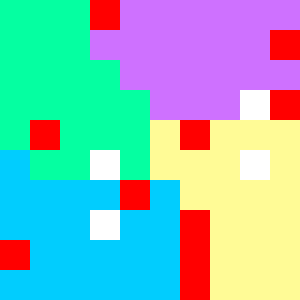

In [68]:
draw_darp_solution(map,problem,solution)

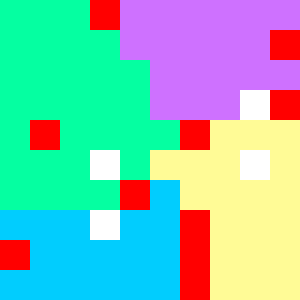

In [69]:
f = list(d)
f[-1]

In [1920]:
sol1 = serialize_classifier_solution(map, problem, solution, [clf1, clf2, clf3, clf4])
d = draw_serialized_solution(map, problem, sol1)

In [1919]:
next(d)

In [13]:
dataset0[2][0]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 